In [32]:
import pandas as pd
import numpy as np
from scipy.stats import ks_2samp
import glob
import os
import dotenv
import matplotlib.pyplot as plt
import geopandas as gpd
import string

import warnings
warnings.filterwarnings("ignore")

dotenv.load_dotenv()
main_dir = os.getenv("path")
directory = os.getenv("output_dir")

In [24]:
def tenYearsforAMetric(dir_path: str, flow_metric: str) -> pd.DataFrame:
    stations_df = pd.read_csv(os.path.join(main_dir, "raw_data", "stations_list.csv"))
    station_list = stations_df["stations"].to_list()
    all_files = glob.glob(os.path.join(dir_path, "*.csv"))
    individual_year = {}

    for file in all_files:
        df = pd.read_csv(file)
        year = file.split("/")[-1].split(".")[0].split("s")[1]
        individual_year[f"{flow_metric}-{year}"] = df[f"{flow_metric}-{year}"]

    individual_metric_df = pd.DataFrame(individual_year)
    individual_metric_df = individual_metric_df.reindex(
        sorted(individual_metric_df.columns), axis=1
    )
    individual_metric_df.insert(0, "station_id", station_list, True)
    individual_metric_df["latitude"] = stations_df["latitude"]
    individual_metric_df["longitude"] = stations_df["longitude"]

    return individual_metric_df

In [25]:
def k_test(gm_df, ngm_df):
    """
        Takes two dataframes (growing-season dataset and non-growing-seaso dataset to create one daframe of p_values)

    """
    # Transpose the dataframes
    gm_t = gm_df.iloc[:, 1:11].transpose()
    ngm_t = ngm_df.iloc[:, 1:11].transpose()

    p_values = []

    for column in gm_t.columns:
        data1 = list(gm_t[column].values)
        data2 = list(ngm_t[column].values)

        # Perform the KS test
        _, p_value = ks_2samp(data1, data2)
        p_values.append(p_value)
    column_name = f'p-value_{gm_df.columns[1].split("-")[-2]}'
    pvalues_df = pd.DataFrame({column_name: p_values})

    plot_df = pvalues_df.applymap(lambda x: x if pd.isna(x) else 1 if x >= 0.05 else 2)

    return plot_df

# test:
datasetPath = os.path.join(directory, "flow_data")
gm_df = tenYearsforAMetric(datasetPath, flow_metric= "Specific-GM-Q5")
ngm_df = tenYearsforAMetric(datasetPath, flow_metric="Specific-GM-Q5")

q5 = k_test(gm_df = gm_df, ngm_df=ngm_df)

# Plotting Seasonal River Flow Regime

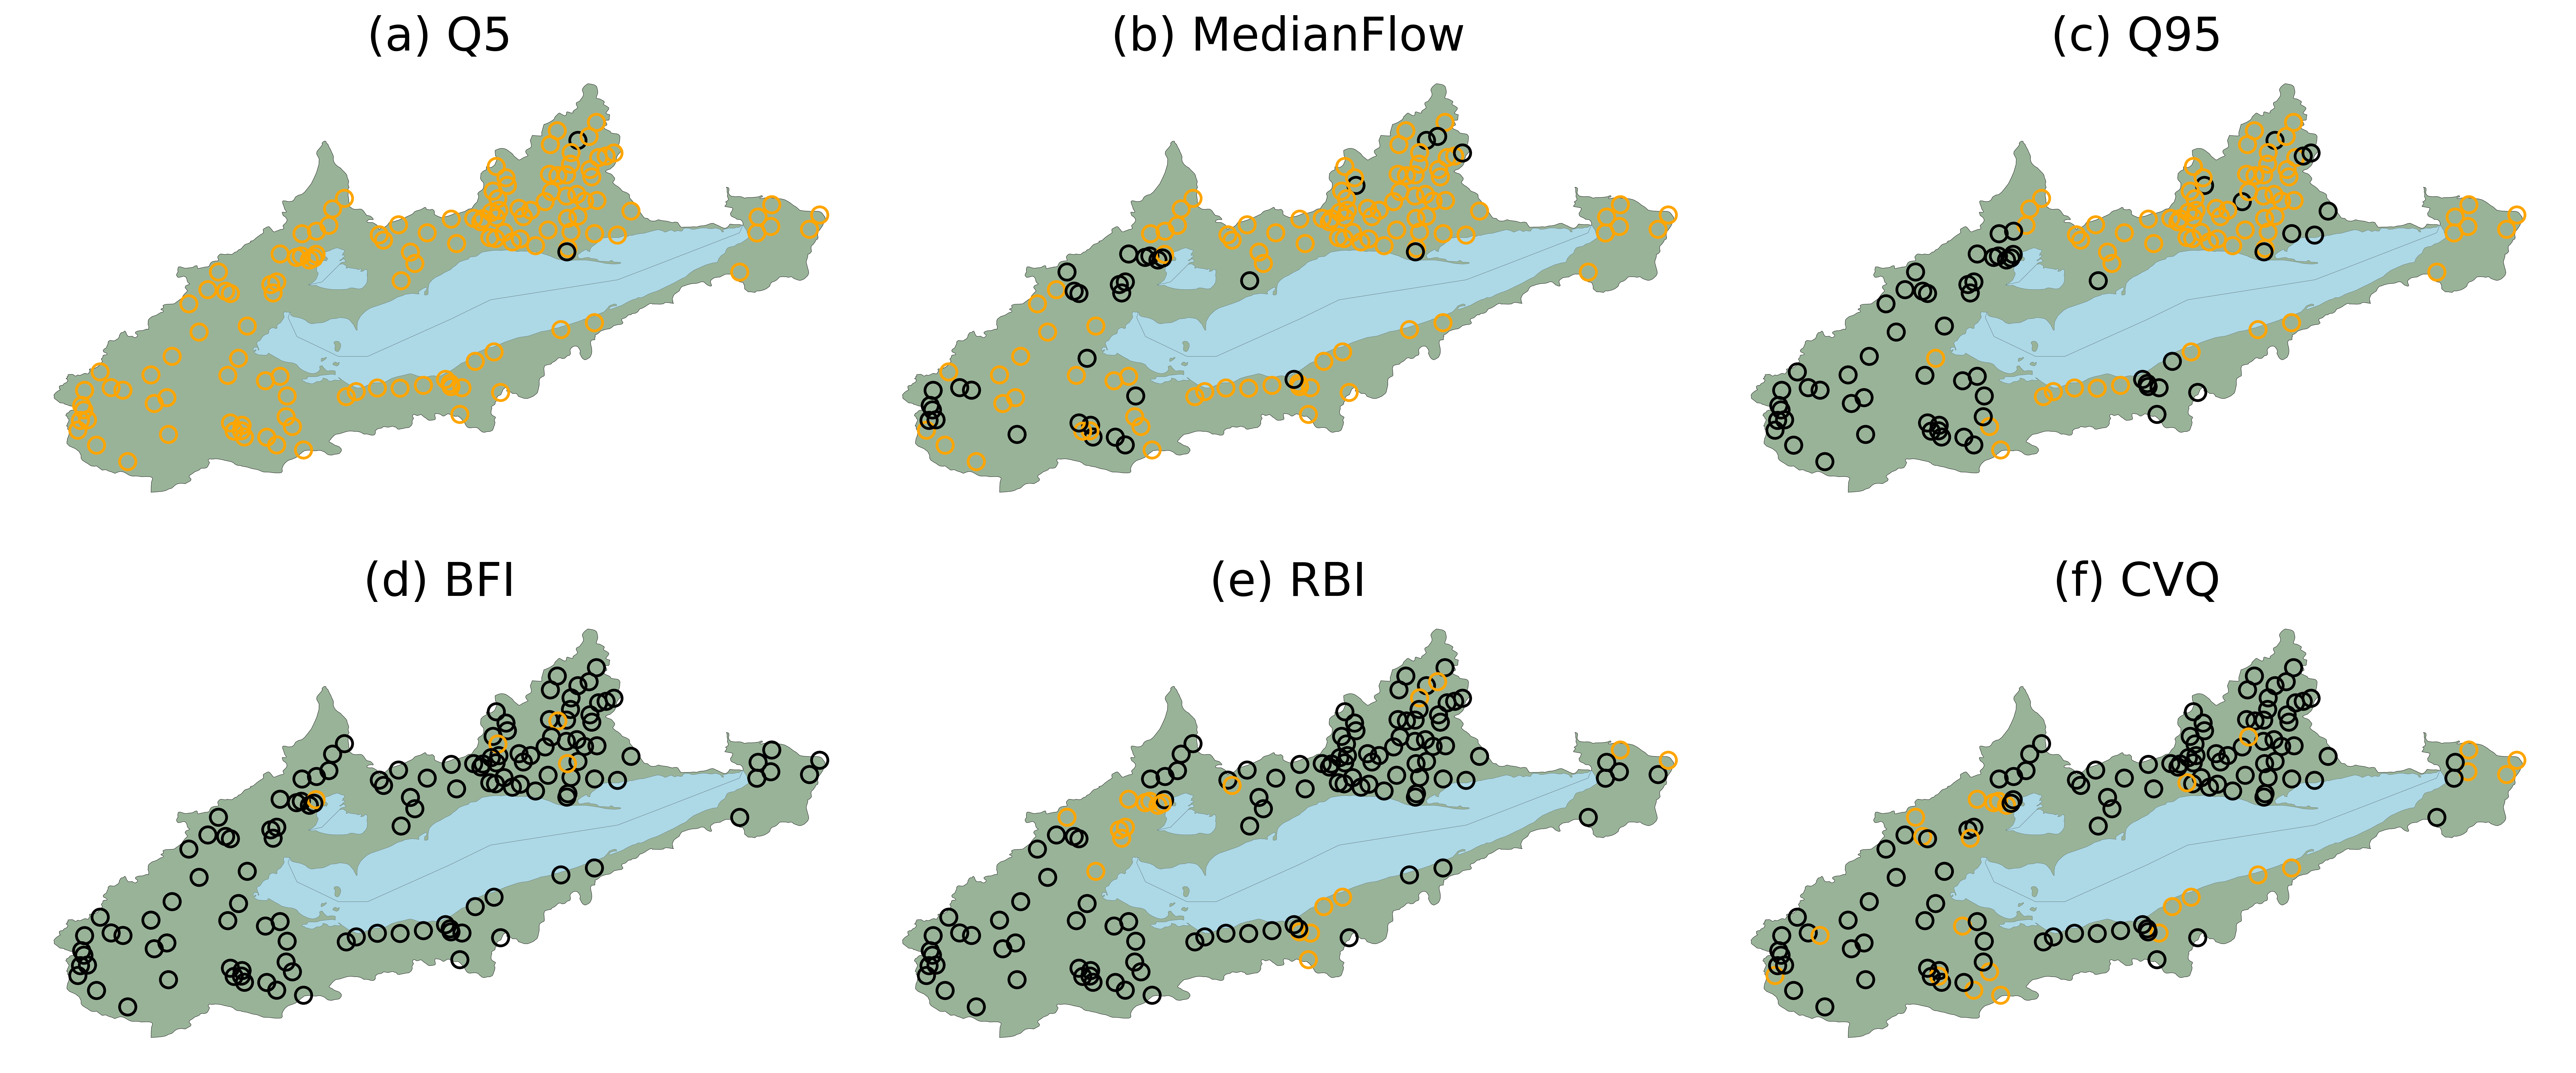

In [36]:
seasonal_metrics = [("Specific-GM-Q5","Specific-NGM-Q5"), ("Specific-GM-MedianFlow","Specific-NGM-MedianFlow"), ("Specific-GM-Q95","Specific-NGM-Q95"), ("GM-BFI","NGM-BFI"), ("GM-RBI","NGM-RBI"), ("GM-CVQ","NGM-CVQ")]
df_collector = []

for gm, ngm in seasonal_metrics:
    gm_df = tenYearsforAMetric(datasetPath, flow_metric= gm)
    ngm_df = tenYearsforAMetric(datasetPath, flow_metric= ngm)
    df = k_test(gm_df = gm_df, ngm_df=ngm_df)
    df_collector.append(df)

pvalue_combined_df = pd.concat(df_collector, axis=1)

stations_df = pd.read_csv(os.path.join(main_dir, "raw_data", "stations_list.csv"))
gdf_to_plot = gpd.GeoDataFrame(pvalue_combined_df, geometry = gpd.points_from_xy(stations_df.longitude, stations_df.latitude))


LEB_polygon = gpd.read_file(os.path.join(main_dir, "LEB_description", "sub-basin _ArcGIS", "LakeErieBasinBoundaries.shp"))
Lake = gpd.read_file(os.path.join(main_dir, "LEB_description", "sub-basin _ArcGIS", "LakeErie.shp"))
st_clair = gpd.read_file(os.path.join(main_dir, "LEB_description", "sub-basin _ArcGIS", "hydro_p_LakeStClair", "hydro_p_LakeStClair.shp"))


f, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (24, 12), dpi=500)
axs = axs.flatten()

metric_names = list(pvalue_combined_df.columns[:])
labels = [label.split("_")[-1] for label in metric_names]

for i, col in enumerate(metric_names):

        ax = axs[i]
        ax.set_aspect('auto')

        LEB_polygon.to_crs(epsg=4326).plot(ax=ax, color=(0.6,0.7,0.6),edgecolor="black", linewidth=0.15, markersize=1000)
        Lake.to_crs(epsg=4326).plot(ax=ax, color='lightblue',edgecolor="black", linewidth=0.05, markersize=1000)
        st_clair.to_crs(epsg=4326).plot(ax=ax, color='lightblue',edgecolor="black", linewidth=0.05, markersize=1000)

        gdf_to_plot.plot(column = col, ax=ax,linewidth=0.1,edgecolor="blue",
                 legend = False, markersize = 10,alpha=0)


        for idx, row in gdf_to_plot.iterrows():
            if row[col] == 1:
                marker = 'o'
                ax.scatter(row.geometry.x, row.geometry.y, marker=marker, color='none', s=60,linewidth=1.3, edgecolors='black' )
            elif row[col] == 2:
                marker = 'o'
                ax.scatter(row.geometry.x, row.geometry.y, marker=marker, color='none', s=60,linewidth=1.3, edgecolors='orange')
            else:
                continue

        ax.set_axis_off()
        ax.set_title(col)

        title_str = f"({string.ascii_lowercase[i]}) {labels[i]}"
        ax.set_title(title_str, size=22)
        ax.tick_params(labelsize=1)

plt.subplots_adjust(hspace=-.5,wspace=0, left = 0, right =.7, top = .9, bottom = 0)
plt.show()